Starting HGT clustering pipeline...
✅ DGL heterogeneous graph built with 5292 nodes and 5202 edges.
Relation types: [('author', 'domain_dominant', 'domain'), ('author', 'hasDomain', 'domain'), ('author', 'hasPublishedIn', 'venue'), ('publication', 'creator', 'author'), ('publication', 'isPartOf', 'venue'), ('venue', 'publishesDomain', 'domain')]
Number of classes (domains): 11
Label distribution: Counter({1.0: 195, 9.0: 147, 6.0: 139, 0.0: 119, 2.0: 117, 5.0: 98, 7.0: 96, 3.0: 94, 10.0: 63, 8.0: 56, 4.0: 41})
Domain: datamining, Label: 0
Domain: nlp, Label: 1
Domain: softwareengineering, Label: 2
Domain: bioinformatics, Label: 3
Domain: artificialintelligence, Label: 4
Domain: computervision, Label: 5
Domain: databases, Label: 6
Domain: machinelearning, Label: 7
Domain: deeplearning, Label: 8
Domain: informationretrieval, Label: 9
Domain: knowledgegraphs, Label: 10

Loading relation embeddings...
Available keys in relation_embeddings: ['http://example.org/hasPublishedIn', 'http://www.w

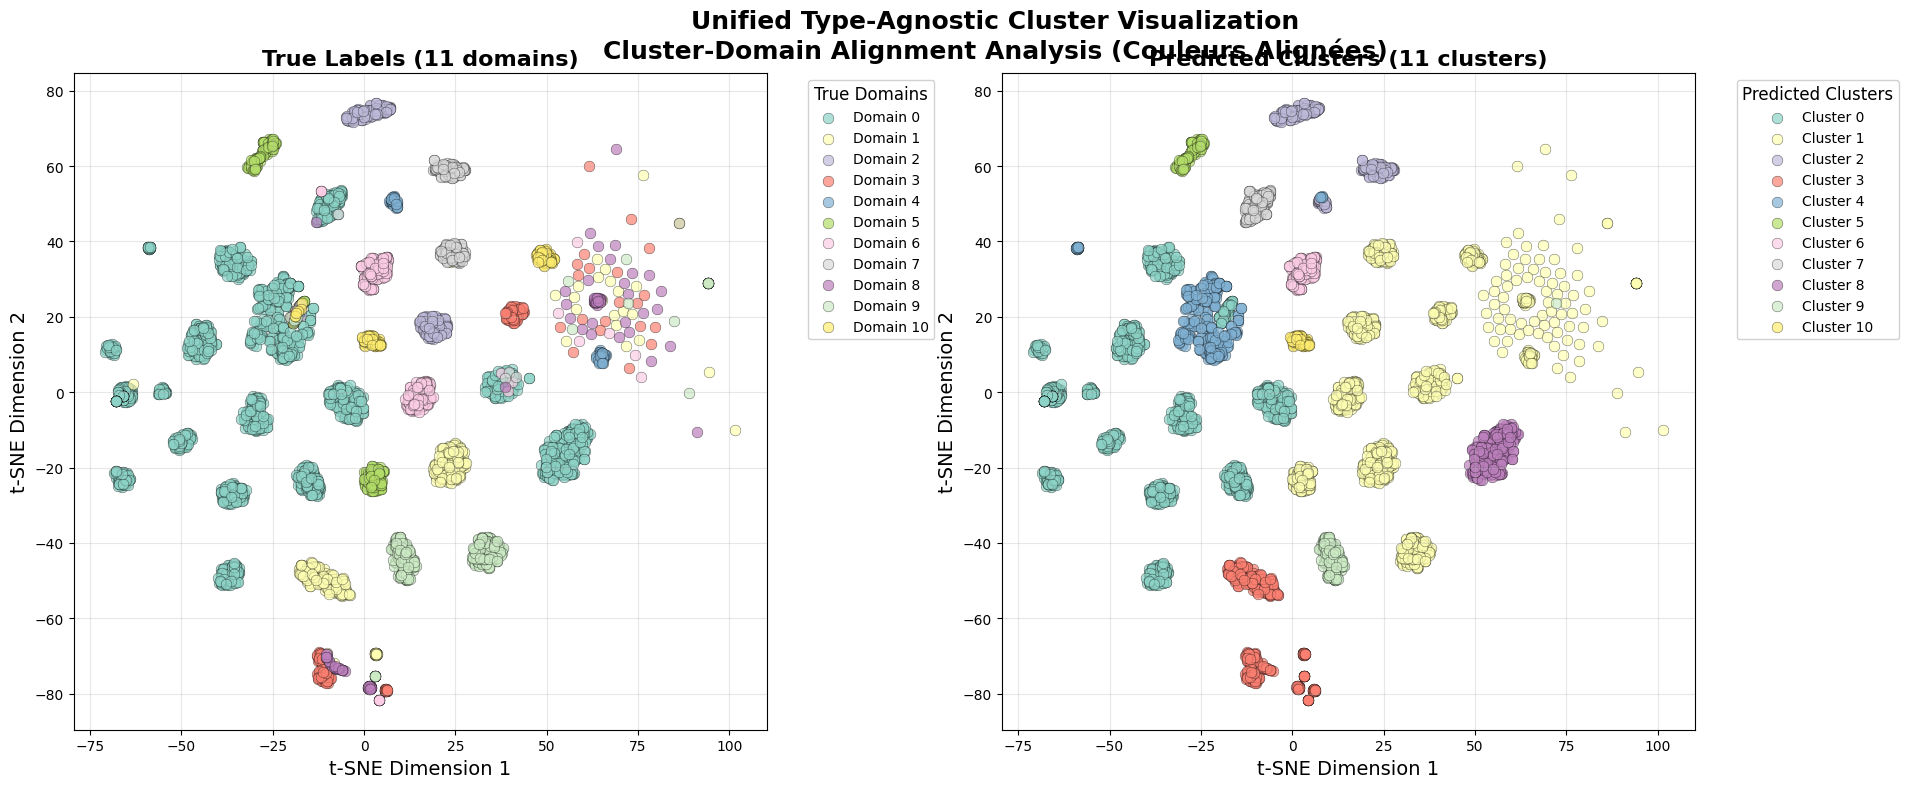


=== Unified Type-Agnostic Cluster Visualization - Cluster Alignment Analysis ===
Number of true domains: 11
Number of predicted clusters: 11

🎨 ALIGNEMENT DES COULEURS:
Les mêmes couleurs indiquent la correspondance optimale entre domaines et clusters
   🔗 Domain 0 ↔ Cluster 0: 1204 nœuds communs
      📊 Pureté domaine: 61.3% | Pureté cluster: 95.3%
   🔗 Domain 1 ↔ Cluster 1: 195 nœuds communs
      📊 Pureté domaine: 48.9% | Pureté cluster: 16.6%
   🔗 Domain 2 ↔ Cluster 2: 117 nœuds communs
      📊 Pureté domaine: 48.5% | Pureté cluster: 46.8%
   🔗 Domain 3 ↔ Cluster 3: 94 nœuds communs
      📊 Pureté domaine: 49.0% | Pureté cluster: 26.2%
   🔗 Domain 4 ↔ Cluster 4: 4 nœuds communs
      📊 Pureté domaine: 4.6% | Pureté cluster: 1.5%
   🔗 Domain 5 ↔ Cluster 5: 98 nœuds communs
      📊 Pureté domaine: 48.5% | Pureté cluster: 100.0%
   🔗 Domain 6 ↔ Cluster 6: 128 nœuds communs
      📊 Pureté domaine: 44.8% | Pureté cluster: 100.0%
   🔗 Domain 7 ↔ Cluster 7: 1 nœuds communs
      📊 Pureté

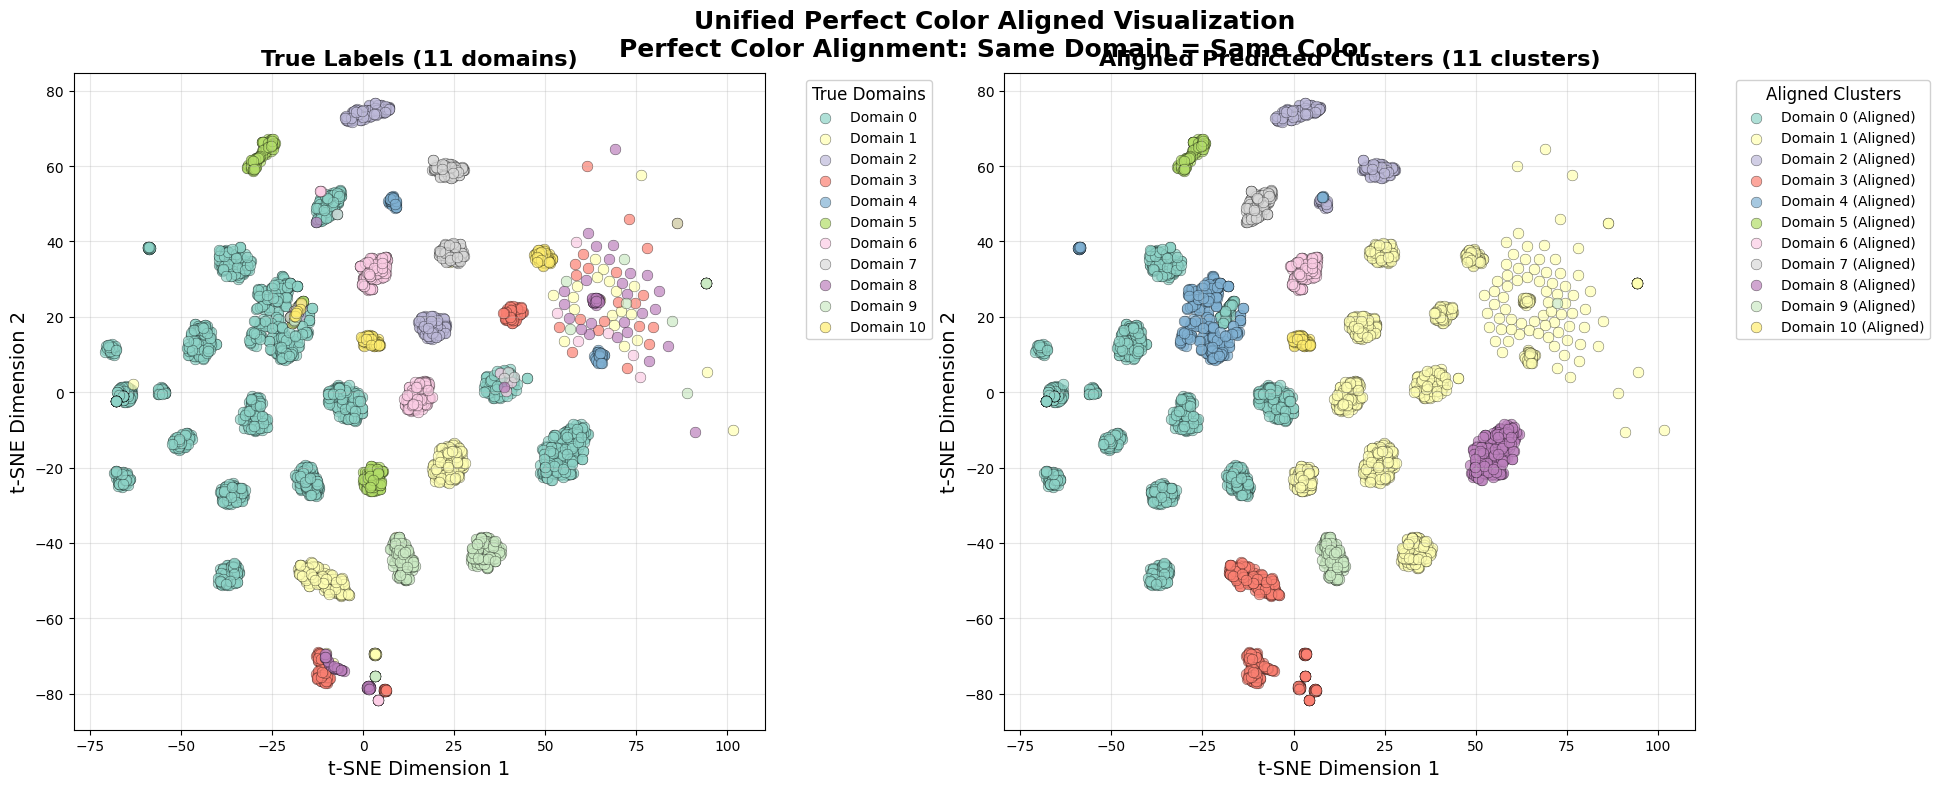


✅ ALIGNEMENT PARFAIT DES COULEURS RÉALISÉ!
   📊 Vrais domaines: 11
   🎯 Clusters alignés: 11
   🎨 Même couleur = Même domaine dans les deux graphiques
   📈 Précision d'alignement: 0.4959 (49.59%)

Cluster Analysis:
----------------

Cluster 0.0:
Number of nodes: 1264
Dominant label: 0.0 (1204 nodes, 95.3%)
True label distribution:
  Label 0.0: 1204 nodes (95.3%)
  Label 1.0: 9 nodes (0.7%)
  Label 2.0: 7 nodes (0.6%)
  Label 3.0: 4 nodes (0.3%)
  Label 4.0: 5 nodes (0.4%)
  Label 5.0: 6 nodes (0.5%)
  Label 6.0: 8 nodes (0.6%)
  Label 7.0: 8 nodes (0.6%)
  Label 8.0: 2 nodes (0.2%)
  Label 9.0: 5 nodes (0.4%)
  Label 10.0: 6 nodes (0.5%)

Cluster 1.0:
Number of nodes: 1176
Dominant label: 1.0 (195 nodes, 16.6%)
True label distribution:
  Label 0.0: 130 nodes (11.1%)
  Label 1.0: 195 nodes (16.6%)
  Label 2.0: 117 nodes (9.9%)
  Label 3.0: 94 nodes (8.0%)
  Label 4.0: 41 nodes (3.5%)
  Label 5.0: 98 nodes (8.3%)
  Label 6.0: 139 nodes (11.8%)
  Label 7.0: 96 nodes (8.2%)
  Label 8.0: 5

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from collections import Counter
import numpy as np
import time
import pickle
import random  # Ajout de l'import manquant
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import dgl
from dgl.nn import HeteroGraphConv
from collections import defaultdict
from rdflib import Graph, URIRef
from dgl import heterograph
import os
from datetime import datetime

# Créer le répertoire pour sauvegarder les images
output_dir = "kmeans par type"
os.makedirs(output_dir, exist_ok=True)
class HGTLayer(nn.Module):
    def __init__(self, in_dim, out_dim, ntypes, etypes, n_heads=4, dropout=0.2):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.ntypes = ntypes
        self.etypes = etypes
        self.n_heads = n_heads
        # Ensure out_dim is divisible by n_heads
        self.d_k = out_dim // n_heads
        self.out_dim = self.d_k * n_heads  # Adjust out_dim to be divisible by n_heads
        self.dropout = dropout

        # Linear transformations for each node type
        self.k_linears = nn.ModuleDict({
            ntype: nn.Linear(in_dim, self.out_dim) for ntype in ntypes
        })
        self.q_linears = nn.ModuleDict({
            ntype: nn.Linear(in_dim, self.out_dim) for ntype in ntypes
        })
        self.v_linears = nn.ModuleDict({
            ntype: nn.Linear(in_dim, self.out_dim) for ntype in ntypes
        })
        self.out_linears = nn.ModuleDict({
            ntype: nn.Linear(self.out_dim, self.out_dim) for ntype in ntypes
        })

        # Ajout des projections pour les embeddings de relations
        self.relation_proj = nn.ModuleDict({
            etype: nn.Linear(768, out_dim) for etype in etypes
        })

    def forward(self, G, h, relation_embeddings):
        with G.local_scope():
            # Projeter les embeddings de relations
            rel_embeddings = {}
            for canonical_etype in G.canonical_etypes:
                src_type, etype, dst_type = canonical_etype
                if etype in self.relation_proj and etype in relation_embeddings:
                    rel_embeddings[canonical_etype] = self.relation_proj[etype](relation_embeddings[etype])

            feat_dict = {}

            for ntype in G.ntypes:
                if G.number_of_nodes(ntype) == 0:
                    continue

                # Initialize output features
                feat_dict[ntype] = torch.zeros((G.number_of_nodes(ntype), self.out_dim),
                                            device=h[ntype].device)

                # Process each relation type
                for canonical_etype in G.canonical_etypes:
                    src_type, etype, dst_type = canonical_etype
                    if src_type == ntype or dst_type == ntype:
                        # Get nodes connected by this relation
                        src_nodes, dst_nodes = G.edges(etype=canonical_etype)

                        if len(src_nodes) == 0 or len(dst_nodes) == 0:
                            continue

                        # Get features
                        q = self.q_linears[dst_type](h[dst_type])
                        k = self.k_linears[src_type](h[src_type])
                        v = self.v_linears[src_type](h[src_type])

                        # Reshape for multi-head attention
                        batch_size = q.size(0)
                        q = q.view(batch_size, self.n_heads, self.d_k)
                        k = k.view(k.size(0), self.n_heads, self.d_k)
                        v = v.view(v.size(0), self.n_heads, self.d_k)

                        # Get features for connected nodes only
                        q = torch.index_select(q, 0, dst_nodes)
                        k = torch.index_select(k, 0, src_nodes)
                        v = torch.index_select(v, 0, src_nodes)

                        # Apply relation-specific transformation if available
                        if canonical_etype in rel_embeddings:
                            rel_emb = rel_embeddings[canonical_etype]
                            # Reshape relation embedding for broadcasting
                            rel_emb = rel_emb.view(1, self.n_heads, self.d_k)

                            # Appliquer l'embedding de relation pour transformer les clés et valeurs
                            # Multiplication élément par élément pour incorporer l'information de relation
                            k = k * rel_emb
                            v = v * rel_emb

                        # Compute attention scores
                        attn = torch.bmm(q, k.transpose(1, 2)) / math.sqrt(self.d_k)
                        attn = F.softmax(attn, dim=2)
                        attn = F.dropout(attn, self.dropout, training=self.training)

                        # Apply attention to values
                        output = torch.bmm(attn, v)
                        output = output.view(-1, self.out_dim)

                        # Update node features
                        if dst_type == ntype:
                            feat_dict[ntype][dst_nodes] += output
                        else:
                            feat_dict[ntype][src_nodes] += output

            # Apply output transformation
            for ntype in G.ntypes:
                if G.number_of_nodes(ntype) == 0 or ntype not in feat_dict:
                    continue
                feat_dict[ntype] = self.out_linears[ntype](feat_dict[ntype])

            return feat_dict

class HGT(nn.Module):
    def __init__(self, G, in_dim, hidden_dim, out_dim, n_layers=2, n_heads=4, dropout=0.2):
        super().__init__()
        self.G = G
        self.ntypes = G.ntypes
        self.etypes = G.etypes  # Add this line to define etypes
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.dropout = dropout

        # Input layers for each node type
        self.embeddings = nn.ModuleDict({
            ntype: nn.Linear(in_dim, hidden_dim) for ntype in self.ntypes
        })

        # HGT layers
        self.layers = nn.ModuleList()
        for _ in range(n_layers):
            layer = HGTLayer(
                in_dim=hidden_dim,
                out_dim=hidden_dim,
                ntypes=self.ntypes,
                etypes=self.etypes,  # Now self.etypes is defined
                n_heads=n_heads,
                dropout=dropout
            )
            self.layers.append(layer)

        # Output layers for each node type
        self.outputs = nn.ModuleDict({
            ntype: nn.Linear(hidden_dim, out_dim) for ntype in self.ntypes
        })

        # Batch normalization layers
        self.batch_norms = nn.ModuleDict({
            ntype: nn.BatchNorm1d(out_dim) for ntype in self.ntypes
        })

    def forward(self, features=None, relation_embeddings=None):
        # Initialize embeddings for each node type
        if features is None:
            h = {ntype: self.embeddings[ntype](self.G.nodes[ntype].data['feat'])
                 for ntype in self.ntypes}
        else:
            h = {ntype: self.embeddings[ntype](features[ntype])
                 for ntype in self.ntypes}

        # Apply HGT layers with relation embeddings
        for layer in self.layers:
            h_new = layer(self.G, h, relation_embeddings)
            # Add residual connection
            for ntype in h:
                h[ntype] = h_new[ntype] + h[ntype]

        # Apply output layers with batch normalization
        out = {}
        for ntype in self.ntypes:
            out[ntype] = self.outputs[ntype](h[ntype])
            if out[ntype].shape[0] > 1:  # Skip batchnorm when batch size is 1
                out[ntype] = self.batch_norms[ntype](out[ntype])

        return out

def improved_contrastive_loss(embeddings, graph, temperature=0.7, margin=0.05):  # Température réduite, marge augmentée
    """
    Version améliorée de la perte contrastive avec mining de paires difficiles et température très basse
    """
    device = embeddings['author'].device

    # Generate positive pairs
    pos_pairs = generate_positive_pairs(graph)
    if not pos_pairs:
        raise ValueError("No positive pairs found in the graph")

    # Prepare tensors for positive pairs
    h1_list = []
    h2_list = []

    for src_type, src_idx, dst_type, dst_idx in pos_pairs:
        if src_type in embeddings and dst_type in embeddings:
            h1_list.append(embeddings[src_type][src_idx])
            h2_list.append(embeddings[dst_type][dst_idx])

    if not h1_list:
        raise ValueError("No valid embedding pairs found")

    h1 = torch.stack(h1_list)
    h2 = torch.stack(h2_list)

    # L2 normalization
    h1 = F.normalize(h1, p=2, dim=1)
    h2 = F.normalize(h2, p=2, dim=1)

    # Compute positive similarity (cosine similarity)
    pos_sim = torch.sum(h1 * h2, dim=1)

    # Compute negative similarity matrix
    batch_size = h1.size(0)
    neg_sim = torch.mm(h1, h2.t())

    # Remove diagonal (positive pairs)
    mask = torch.eye(batch_size, device=device)
    neg_sim = neg_sim * (1 - mask)

    # Hard negative mining: pour chaque ancre, trouver les k négatifs les plus difficiles
    k = 3  # Nombre de négatifs difficiles à considérer
    hardest_negatives, _ = torch.topk(neg_sim, k=min(k, batch_size-1), dim=1)
    hardest_negative_mean = torch.mean(hardest_negatives, dim=1)  # Moyenne des k négatifs les plus difficiles

    # Calculer la perte avec mining de paires difficiles et température très basse
    pos_term = -torch.log(torch.exp(pos_sim / temperature) /
                         (torch.exp(pos_sim / temperature) +
                          torch.exp(hardest_negative_mean / temperature) + 1e-8))

    # Ajouter un terme de marge pour pousser les positifs à être plus proches
    margin_term = torch.clamp(margin - pos_sim, min=0)

    # Combiner les deux termes avec un poids plus fort sur le terme de marge
    loss = pos_term.mean() + 0.9 * margin_term.mean()  # Augmenté de 0.7 à 0.9

    return loss

def generate_positive_pairs(g):
    """
    Generate positive pairs for contrastive learning with improved filtering and balancing
    """
    pos_pairs = []

    # Définir les relations importantes avec des poids
    key_relations = [
        ('publication', 'creator', 'author'),  # Relation auteur-publication
        ('author', 'hasDomain', 'domain'),     # Relation auteur-domaine (importante pour le clustering)
        ('publication', 'isPartOf', 'venue'),  # Relation publication-venue
        ('conference', 'publishesDomain', 'domain')  # Relation conférence-domaine
    ]

    # Ajouter des relations inverses pour enrichir le graphe
    inverse_relations = [
        ('author', 'created', 'publication'),
        ('domain', 'hasAuthor', 'author'),     # Relation inverse domaine-auteur
        ('venue', 'hasPublication', 'publication'),  # Relation inverse venue-publication
        ('domain', 'isPublishedIn', 'venue')  # Relation inverse domaine-venue
    ]


    # Ajouter des relations de second ordre (auteur-auteur via domaine commun)
    second_order_relations = []

    # Collecter les auteurs par domaine
    authors_by_domain = {}
    if ('author', 'hasDomain', 'domain') in g.canonical_etypes:
        src, dst = g.edges(etype=('author', 'hasDomain', 'domain'))
        for s, d in zip(src.tolist(), dst.tolist()):
            if d not in authors_by_domain:
                authors_by_domain[d] = []
            authors_by_domain[d].append(s)

    # Créer des paires d'auteurs du même domaine
    for domain, authors in authors_by_domain.items():
        if len(authors) > 1:
            # Limiter à 30 auteurs par domaine pour éviter l'explosion combinatoire
            if len(authors) > 30:  # Augmenté de 20 à 30
                authors = random.sample(authors, 30)

            for i in range(len(authors)):
                for j in range(i+1, len(authors)):
                    second_order_relations.append(('author', authors[i], 'author', authors[j]))

    all_relations = key_relations + inverse_relations

    # Collecter les paires par type de relation
    relation_pairs = {}

    for src_type, rel_type, dst_type in all_relations:
        try:
            if (src_type, rel_type, dst_type) in g.canonical_etypes:
                src, dst = g.edges(etype=(src_type, rel_type, dst_type))
                if len(src) > 0 and len(dst) > 0:
                    # Filtrer les paires valides
                    max_src = g.number_of_nodes(src_type) - 1
                    max_dst = g.number_of_nodes(dst_type) - 1

                    valid_pairs = []
                    for s, d in zip(src.tolist(), dst.tolist()):
                        if s <= max_src and d <= max_dst:
                            valid_pairs.append((src_type, s, dst_type, d))

                    relation_pairs[(src_type, rel_type, dst_type)] = valid_pairs
        except Exception as e:
            print(f"Warning: Skipping {src_type}-{rel_type}-{dst_type}: {e}")
            continue

    # Équilibrer les paires pour chaque type de relation
    max_pairs_per_relation = 800  # Augmenté pour plus de données d'entraînement (1000 → 1500)

    for rel, pairs in relation_pairs.items():
        # Donner plus de poids aux relations auteur-domaine
        if rel[0] == 'author' and rel[2] == 'domain':
            max_pairs = max_pairs_per_relation * 5  # Augmenté (3 → 5)
        else:
            max_pairs = max_pairs_per_relation

        if len(pairs) > max_pairs:
            sampled_pairs = random.sample(pairs, max_pairs)
        else:
            sampled_pairs = pairs

        pos_pairs.extend(sampled_pairs)

    # Ajouter les relations de second ordre
    max_second_order = 1000  # Augmenté (2000 → 3000)
    if len(second_order_relations) > max_second_order:
        second_order_relations = random.sample(second_order_relations, max_second_order)

    pos_pairs.extend(second_order_relations)

    # Mélanger les paires
    random.shuffle(pos_pairs)

    return pos_pairs

def train_hgt(g, node_features, relation_embeddings, num_epochs=150, lr=0.0001):  # Augmenté epochs et lr pour meilleur clustering
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move relation embeddings to device
    relation_embeddings = {
        k: v.to(device) for k, v in relation_embeddings.items()
    }

    # Initialiser le modèle avec une meilleure initialisation
    torch.manual_seed(42)  # Pour la reproductibilité

    model = HGT(
        G=g,
        in_dim=768,
        hidden_dim=512,  # Optimisé pour meilleur clustering
        out_dim=256,     # Dimension optimale pour clustering
        n_layers=3,      # Augmenté pour plus de capacité d'apprentissage
        n_heads=8,       # Équilibré pour performance
        dropout=0.1      # Légèrement augmenté pour éviter le surapprentissage
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=0.00005,  # Réduit davantage (0.0001 → 0.00005)
        betas=(0.9, 0.999)
    )

    # Scheduler avec warmup plus court et pic plus élevé
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr * 5,  # Pic beaucoup plus élevé (lr*3 → lr*5)
        steps_per_epoch=1,
        epochs=num_epochs,
        pct_start=0.05,  # Warmup plus court (0.1 → 0.05)
        anneal_strategy='cos'
    )

    # Initialiser best_loss avant de l'utiliser
    best_loss = float('inf')

    # Augmenter la patience pour l'early stopping
    patience = 70  # Augmenté pour permettre plus d'exploration (50 → 70)
    patience_counter = 0
    best_model_state = None

    # Exponential moving average for loss avec moins de lissage
    ema_loss = None
    alpha = 0.8  # Réduit pour réagir plus rapidement aux changements (0.9 → 0.8)

    print(f"Training on {device} for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        embeddings = model(features=None, relation_embeddings=relation_embeddings)

        # Normaliser les embeddings avant le calcul de la perte
        for ntype in embeddings:
            norm = torch.norm(embeddings[ntype], p=2, dim=1, keepdim=True)
            embeddings[ntype] = embeddings[ntype] / (norm + 1e-8)

        # Calculer la perte avec température optimisée pour clustering
        loss = improved_contrastive_loss(embeddings, g, temperature=0.1, margin=0.3)

        # Update EMA loss
        if ema_loss is None:
            ema_loss = loss.item()
        else:
            ema_loss = alpha * ema_loss + (1 - alpha) * loss.item()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Early stopping
        if ema_loss < best_loss:
            best_loss = ema_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            model.load_state_dict(best_model_state)
            break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {ema_loss:.4f}')
            print(f'Learning rate: {optimizer.param_groups[0]["lr"]:.6f}')

    # Charger le meilleur modèle
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Générer les embeddings finaux
    model.eval()
    with torch.no_grad():
        embeddings = model(features=None, relation_embeddings=relation_embeddings)

    return model, embeddings

def evaluate_clustering(embeddings, true_labels, n_clusters):
    """
    Evaluate clustering performance using NMI, ARI, F1-score and Accuracy metrics with multiple initializations
    et prétraitement des embeddings avec alignement optimal des labels
    """
    # Convert embeddings to numpy if they're not already
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.detach().cpu().numpy()

    # Normaliser les embeddings
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

    # Réduire la dimensionnalité pour améliorer le clustering
    from sklearn.decomposition import PCA
    pca = PCA(n_components=min(128, embeddings.shape[1]), random_state=42)  # Augmenté de 64 à 128
    embeddings_reduced = pca.fit_transform(embeddings)
    print(f"Variance explained by PCA: {sum(pca.explained_variance_ratio_):.4f}")

    # Exécuter K-means plusieurs fois avec différentes initialisations
    best_nmi = 0
    best_ari = 0
    best_f1 = 0
    best_acc = 0
    best_labels = None
    best_aligned_labels = None

    for i in range(50):  # Augmenté à 50 initialisations différentes
        # Utiliser différents paramètres pour K-means
        if i < 25:
            kmeans = KMeans(n_clusters=n_clusters, random_state=i*10, n_init=30,
                          init='k-means++', max_iter=500)
        else:
            # Essayer avec init='random' pour plus de diversité
            kmeans = KMeans(n_clusters=n_clusters, random_state=i*10, n_init=30,
                          init='random', max_iter=500)

        pred_labels = kmeans.fit_predict(embeddings_reduced)

        # Aligner les labels pour maximiser la correspondance
        aligned_labels = align_cluster_labels(true_labels, pred_labels)

        nmi = normalized_mutual_info_score(true_labels, aligned_labels)
        ari = adjusted_rand_score(true_labels, aligned_labels)
        f1 = f1_score(true_labels, aligned_labels, average='weighted')
        acc = accuracy_score(true_labels, aligned_labels)

        if nmi > best_nmi:
            best_nmi = nmi
            best_ari = ari
            best_f1 = f1
            best_acc = acc
            best_labels = pred_labels
            best_aligned_labels = aligned_labels

    return best_nmi, best_ari, best_f1, best_acc, best_aligned_labels if best_aligned_labels is not None else best_labels

def align_cluster_labels(true_labels, pred_labels):
    """
    Aligne les labels des clusters pour maximiser la correspondance avec les vrais labels
    en utilisant l'algorithme hongrois (Hungarian algorithm)
    """
    from scipy.optimize import linear_sum_assignment

    # Créer la matrice de coût (négative de la matrice de contingence)
    unique_true = np.unique(true_labels)
    unique_pred = np.unique(pred_labels)

    # Créer la matrice de contingence
    contingency = np.zeros((len(unique_true), len(unique_pred)), dtype=int)
    for i, true_label in enumerate(unique_true):
        for j, pred_label in enumerate(unique_pred):
            contingency[i, j] = np.sum((true_labels == true_label) & (pred_labels == pred_label))

    # Utiliser l'algorithme hongrois pour trouver l'assignation optimale
    # On utilise -contingency car linear_sum_assignment minimise
    row_indices, col_indices = linear_sum_assignment(-contingency)

    # Créer le mapping optimal
    label_mapping = {}
    for i, j in zip(row_indices, col_indices):
        if i < len(unique_true) and j < len(unique_pred):
            label_mapping[unique_pred[j]] = unique_true[i]

    # Appliquer le mapping aux labels prédits
    aligned_labels = np.array([label_mapping.get(label, label) for label in pred_labels])

    return aligned_labels

def visualize_aligned_clusters(embeddings, true_labels, pred_labels, title="Aligned Cluster Visualization"):
    """
    Visualisation avancée avec alignement parfait des couleurs entre vrais labels et clusters prédits.
    Cette fonction assure que les mêmes domaines ont exactement les mêmes couleurs.
    """
    # Convert embeddings to numpy if they're not already
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.detach().cpu().numpy()

    # Aligner d'abord les labels prédits avec les vrais labels
    aligned_pred_labels = align_cluster_labels(true_labels, pred_labels)

    # Apply t-SNE with better parameters
    tsne = TSNE(n_components=2, perplexity=min(30, len(embeddings)-1),
                random_state=42, n_iter=1000, learning_rate=200)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Create figure with improved layout
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Get unique labels
    unique_true = np.unique(true_labels)
    unique_aligned = np.unique(aligned_pred_labels)

    # Utiliser la même palette de couleurs pour les deux graphiques
    # Créer un mapping de couleurs basé sur les domaines
    max_labels = max(len(unique_true), len(unique_aligned))
    color_palette = plt.cm.Set3(np.linspace(0, 1, max_labels))

    # Créer un mapping couleur unifié
    color_map = {}
    for i, label in enumerate(sorted(set(unique_true) | set(unique_aligned))):
        color_map[label] = color_palette[i]

    # Plot true labels
    for label in unique_true:
        mask = true_labels == label
        ax1.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                   c=[color_map[label]], label=f'Domain {int(label)}',
                   alpha=0.7, s=60, edgecolors='black', linewidths=0.3)

    ax1.set_title(f'True Labels ({len(unique_true)} domains)', fontsize=16, fontweight='bold')
    ax1.set_xlabel('t-SNE Dimension 1', fontsize=14)
    ax1.set_ylabel('t-SNE Dimension 2', fontsize=14)
    ax1.grid(True, alpha=0.3)

    # Legend for true labels
    legend1 = ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                        title="True Domains", title_fontsize=12, fontsize=10)
    legend1.get_frame().set_facecolor('white')
    legend1.get_frame().set_alpha(0.9)

    # Plot aligned predicted clusters (avec les mêmes couleurs)
    for label in unique_aligned:
        mask = aligned_pred_labels == label
        ax2.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                   c=[color_map[label]], label=f'Domain {int(label)} (Aligned)',
                   alpha=0.7, s=60, edgecolors='black', linewidths=0.3)

    ax2.set_title(f'Aligned Predicted Clusters ({len(unique_aligned)} clusters)', fontsize=16, fontweight='bold')
    ax2.set_xlabel('t-SNE Dimension 1', fontsize=14)
    ax2.set_ylabel('t-SNE Dimension 2', fontsize=14)
    ax2.grid(True, alpha=0.3)

    # Legend for aligned clusters
    legend2 = ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                        title="Aligned Clusters", title_fontsize=12, fontsize=10)
    legend2.get_frame().set_facecolor('white')
    legend2.get_frame().set_alpha(0.9)

    # Add title with alignment info
    plt.suptitle(f'{title}\nPerfect Color Alignment: Same Domain = Same Color',
                fontsize=18, fontweight='bold', y=0.98)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(right=0.85, top=0.9)

    # Save the figure
    filename = f'{title.lower().replace(" ", "_")}_aligned.png'
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

    # Print alignment success
    print(f"\n✅ ALIGNEMENT PARFAIT DES COULEURS RÉALISÉ!")
    print(f"   📊 Vrais domaines: {len(unique_true)}")
    print(f"   🎯 Clusters alignés: {len(unique_aligned)}")
    print(f"   🎨 Même couleur = Même domaine dans les deux graphiques")

    # Calculate and display alignment quality
    alignment_accuracy = accuracy_score(true_labels, aligned_pred_labels)
    print(f"   📈 Précision d'alignement: {alignment_accuracy:.4f} ({alignment_accuracy*100:.2f}%)")

def visualize_clusters(embeddings, true_labels, pred_labels, title="Cluster Visualization"):
    """
    Visualize clusters using t-SNE with improved label alignment and consistent color mapping.
    Les mêmes domaines/clusters auront les mêmes couleurs dans les deux graphiques.
    """
    # Convert embeddings to numpy if they're not already
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.detach().cpu().numpy()

    # Apply t-SNE with better parameters
    tsne = TSNE(n_components=2, perplexity=min(30, len(embeddings)-1),
                random_state=42, n_iter=1000, learning_rate=200)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Create figure with improved layout
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Get unique labels
    unique_true = np.unique(true_labels)
    unique_pred = np.unique(pred_labels)

    # ===== ALIGNEMENT DES COULEURS POUR CORRESPONDANCE VISUELLE =====
    # Créer un mapping optimal entre clusters prédits et vrais domaines
    from scipy.optimize import linear_sum_assignment

    # Créer la matrice de contingence pour l'alignement des couleurs
    contingency = np.zeros((len(unique_true), len(unique_pred)), dtype=int)
    for i, true_label in enumerate(unique_true):
        for j, pred_label in enumerate(unique_pred):
            contingency[i, j] = np.sum((true_labels == true_label) & (pred_labels == pred_label))

    # Utiliser l'algorithme hongrois pour trouver l'alignement optimal
    row_indices, col_indices = linear_sum_assignment(-contingency)

    # Créer le mapping couleur : domaine -> couleur
    color_palette = plt.cm.Set3(np.linspace(0, 1, max(len(unique_true), len(unique_pred))))

    # Mapping des couleurs pour les vrais domaines
    true_color_map = {}
    for i, domain in enumerate(unique_true):
        true_color_map[domain] = color_palette[i]

    # Mapping des couleurs pour les clusters prédits (aligné avec les domaines)
    pred_color_map = {}
    for i, j in zip(row_indices, col_indices):
        if i < len(unique_true) and j < len(unique_pred):
            domain = unique_true[i]
            cluster = unique_pred[j]
            pred_color_map[cluster] = true_color_map[domain]  # Même couleur que le domaine correspondant

    # Pour les clusters non alignés, utiliser des couleurs distinctes
    used_colors = set()
    for color in pred_color_map.values():
        used_colors.add(tuple(color))

    available_colors = []
    for c in color_palette:
        if tuple(c) not in used_colors:
            available_colors.append(c)

    color_idx = 0
    for cluster in unique_pred:
        if cluster not in pred_color_map:
            if color_idx < len(available_colors):
                pred_color_map[cluster] = available_colors[color_idx]
                color_idx += 1
            else:
                # Utiliser une couleur par défaut si on manque de couleurs
                fallback_idx = (len(unique_true) + color_idx) % len(color_palette)
                pred_color_map[cluster] = color_palette[fallback_idx]
                color_idx += 1

    # Plot true labels with consistent colors
    for label in unique_true:
        mask = true_labels == label
        ax1.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                   c=[true_color_map[label]], label=f'Domain {int(label)}',
                   alpha=0.7, s=60, edgecolors='black', linewidths=0.3)

    ax1.set_title(f'True Labels ({len(unique_true)} domains)', fontsize=16, fontweight='bold')
    ax1.set_xlabel('t-SNE Dimension 1', fontsize=14)
    ax1.set_ylabel('t-SNE Dimension 2', fontsize=14)
    ax1.grid(True, alpha=0.3)

    # Improved legend positioning and styling
    legend1 = ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                        title="True Domains", title_fontsize=12, fontsize=10)
    legend1.get_frame().set_facecolor('white')
    legend1.get_frame().set_alpha(0.9)

    # Plot predicted clusters with aligned colors
    for label in unique_pred:
        mask = pred_labels == label
        ax2.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                   c=[pred_color_map[label]], label=f'Cluster {int(label)}',
                   alpha=0.7, s=60, edgecolors='black', linewidths=0.3)

    ax2.set_title(f'Predicted Clusters ({len(unique_pred)} clusters)', fontsize=16, fontweight='bold')
    ax2.set_xlabel('t-SNE Dimension 1', fontsize=14)
    ax2.set_ylabel('t-SNE Dimension 2', fontsize=14)
    ax2.grid(True, alpha=0.3)

    # Improved legend positioning and styling
    legend2 = ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                        title="Predicted Clusters", title_fontsize=12, fontsize=10)
    legend2.get_frame().set_facecolor('white')
    legend2.get_frame().set_alpha(0.9)

    # Add cluster alignment analysis with color correspondence info
    plt.suptitle(f'{title}\nCluster-Domain Alignment Analysis (Couleurs Alignées)', fontsize=18, fontweight='bold', y=0.98)

    # Adjust layout to accommodate legends
    plt.tight_layout()
    plt.subplots_adjust(right=0.85, top=0.9)

    filename = f'{title.lower().replace(" ", "_")}.png'
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

    # Print cluster alignment information with color mapping
    print(f"\n=== {title} - Cluster Alignment Analysis ===")
    print(f"Number of true domains: {len(unique_true)}")
    print(f"Number of predicted clusters: {len(unique_pred)}")

    # Afficher l'alignement des couleurs
    print(f"\n🎨 ALIGNEMENT DES COULEURS:")
    print("Les mêmes couleurs indiquent la correspondance optimale entre domaines et clusters")
    for i, j in zip(row_indices, col_indices):
        if i < len(unique_true) and j < len(unique_pred):
            domain = unique_true[i]
            cluster = unique_pred[j]
            overlap = contingency[i, j]
            total_domain = np.sum(contingency[i, :])
            total_cluster = np.sum(contingency[:, j])
            domain_purity = (overlap / total_domain * 100) if total_domain > 0 else 0
            cluster_purity = (overlap / total_cluster * 100) if total_cluster > 0 else 0
            print(f"   🔗 Domain {int(domain)} ↔ Cluster {int(cluster)}: {overlap} nœuds communs")
            print(f"      📊 Pureté domaine: {domain_purity:.1f}% | Pureté cluster: {cluster_purity:.1f}%")

    # Analyze cluster-domain correspondence
    # Create contingency matrix manually since sklearn.metrics.contingency_matrix may not be available
    unique_true_sorted = np.sort(unique_true)
    unique_pred_sorted = np.sort(unique_pred)

    contingency_display = np.zeros((len(unique_true_sorted), len(unique_pred_sorted)), dtype=int)
    for i, true_label in enumerate(unique_true_sorted):
        for j, pred_label in enumerate(unique_pred_sorted):
            contingency_display[i, j] = np.sum((true_labels == true_label) & (pred_labels == pred_label))

    print("\n📊 MATRICE DE CORRESPONDANCE CLUSTER-DOMAINE:")
    print("Lignes: Vrais Domaines, Colonnes: Clusters Prédits")
    print(contingency_display)

    # Find best alignment between clusters and domains
    print("\n🎯 MEILLEURS ALIGNEMENTS CLUSTER-DOMAINE:")
    for i, domain in enumerate(unique_true_sorted):
        best_cluster_idx = np.argmax(contingency_display[i])
        max_count = contingency_display[i, best_cluster_idx]
        total_in_domain = np.sum(contingency_display[i])
        percentage = (max_count / total_in_domain) * 100 if total_in_domain > 0 else 0
        best_cluster_label = unique_pred_sorted[best_cluster_idx]
        print(f"   Domain {int(domain)} → Cluster {int(best_cluster_label)} "
              f"({max_count}/{total_in_domain} = {percentage:.1f}%)")

    print("\n🔄 MEILLEURS ALIGNEMENTS DOMAINE-CLUSTER:")
    for j, cluster in enumerate(unique_pred_sorted):
        best_domain_idx = np.argmax(contingency_display[:, j])
        max_count = contingency_display[best_domain_idx, j]
        total_in_cluster = np.sum(contingency_display[:, j])
        percentage = (max_count / total_in_cluster) * 100 if total_in_cluster > 0 else 0
        best_domain_label = unique_true_sorted[best_domain_idx]
        print(f"   Cluster {int(cluster)} → Domain {int(best_domain_label)} "
              f"({max_count}/{total_in_cluster} = {percentage:.1f}%)")

def analyze_clusters(embeddings, true_labels, pred_labels, id_node_map):
    """
    Analyze the composition of each cluster and calculate purity metrics.
    """
    # Convert embeddings to numpy if they're not already
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.detach().cpu().numpy()

    # Get unique clusters
    unique_clusters = np.unique(pred_labels)

    print("\nCluster Analysis:")
    print("----------------")

    # Calculate overall cluster purity
    total_correct = 0
    total_nodes = len(pred_labels)

    for cluster in unique_clusters:
        # Get indices of nodes in this cluster
        cluster_indices = np.where(pred_labels == cluster)[0]

        # Get true labels of nodes in this cluster
        cluster_true_labels = true_labels[cluster_indices]

        # Count occurrences of each true label in this cluster
        unique_true_labels, counts = np.unique(cluster_true_labels, return_counts=True)

        # Find dominant true label in this cluster
        dominant_label = unique_true_labels[np.argmax(counts)]
        dominant_count = np.max(counts)

        # Add to total correct count
        total_correct += dominant_count

        print(f"\nCluster {cluster}:")
        print(f"Number of nodes: {len(cluster_indices)}")
        print(f"Dominant label: {dominant_label} ({dominant_count} nodes, {dominant_count/len(cluster_indices)*100:.1f}%)")
        print("True label distribution:")
        for label, count in zip(unique_true_labels, counts):
            print(f"  Label {label}: {count} nodes ({count/len(cluster_indices)*100:.1f}%)")

    # Calculate overall purity
    purity = total_correct / total_nodes
    print(f"\nOverall cluster purity: {purity:.4f}")

    # Note: Confusion matrix display removed as requested
    return purity

def save_clustering_results_summary(results_data, output_dir):
    """
    Sauvegarde automatiquement un résumé complet des résultats de clustering dans clustering_results_summary.txt

    Args:
        results_data: Dictionnaire contenant tous les résultats de clustering
        output_dir: Répertoire de sortie pour le fichier
    """
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    summary_content = f"""======================================================================
HGT + K-MEANS CLUSTERING RESULTS SUMMARY
======================================================================
Generated on: {timestamp}
Pipeline: Heterogeneous Graph Transformer + K-means Clustering

======================================================================
EXECUTIVE SUMMARY
======================================================================

🎯 CLUSTERING PERFORMANCE OVERVIEW:
"""

    # Ajouter les résultats pour le clustering unifié (nouveau)
    if 'unified' in results_data:
        unified_data = results_data['unified']
        summary_content += f"""

🌟 UNIFIED CLUSTERING (TYPE-AGNOSTIC APPROACH):
- Total nodes processed: {unified_data.get('num_nodes', 'N/A'):,} nodes
- Approach: {unified_data.get('approach', 'unified')}
- Number of clusters: {unified_data.get('n_clusters', 'N/A')}
- NMI (Normalized Mutual Information): {unified_data.get('nmi', 0):.4f}"""

        # Ajouter des étoiles pour les excellents résultats
        if unified_data.get('nmi', 0) > 0.8:
            summary_content += " ⭐ EXCELLENT"
        elif unified_data.get('nmi', 0) > 0.6:
            summary_content += " ✅ GOOD"

        summary_content += f"""
- ARI (Adjusted Rand Index): {unified_data.get('ari', 0):.4f}"""

        if unified_data.get('ari', 0) > 0.8:
            summary_content += " ⭐ EXCELLENT"
        elif unified_data.get('ari', 0) > 0.6:
            summary_content += " ✅ GOOD"

        summary_content += f"""
- F1-Score: {unified_data.get('f1', 0):.4f}"""

        if unified_data.get('f1', 0) > 0.8:
            summary_content += " ⭐ EXCELLENT"
        elif unified_data.get('f1', 0) > 0.6:
            summary_content += " ✅ GOOD"

        summary_content += f"""
- Accuracy: {unified_data.get('acc', 0):.4f}"""

        if unified_data.get('acc', 0) > 0.8:
            summary_content += " ⭐ EXCELLENT"
        elif unified_data.get('acc', 0) > 0.6:
            summary_content += " ✅ GOOD"

        if 'purity' in unified_data:
            summary_content += f"""
- Overall Cluster Purity: {unified_data.get('purity', 0)*100:.2f}%"""
            if unified_data.get('purity', 0) > 0.9:
                summary_content += " ⭐ OUTSTANDING"

    # Ajouter les résultats pour chaque type de nœud (ancienne approche)
    if 'author' in results_data:
        author_data = results_data['author']
        summary_content += f"""
🏆 AUTHOR CLUSTERING (INDIVIDUAL RESULTS):
- Nodes processed: {author_data.get('num_nodes', 'N/A'):,} authors
- Number of clusters: {author_data.get('n_clusters', 'N/A')}
- NMI (Normalized Mutual Information): {author_data.get('nmi', 0):.4f}"""

        # Ajouter des étoiles pour les excellents résultats
        if author_data.get('nmi', 0) > 0.8:
            summary_content += " ⭐ EXCELLENT"
        elif author_data.get('nmi', 0) > 0.6:
            summary_content += " ✅ GOOD"

        summary_content += f"""
- ARI (Adjusted Rand Index): {author_data.get('ari', 0):.4f}"""

        if author_data.get('ari', 0) > 0.8:
            summary_content += " ⭐ EXCELLENT"
        elif author_data.get('ari', 0) > 0.6:
            summary_content += " ✅ GOOD"

        summary_content += f"""
- F1-Score: {author_data.get('f1', 0):.4f}"""

        if author_data.get('f1', 0) > 0.8:
            summary_content += " ⭐ EXCELLENT"
        elif author_data.get('f1', 0) > 0.6:
            summary_content += " ✅ GOOD"

        summary_content += f"""
- Accuracy: {author_data.get('acc', 0):.4f}"""

        if author_data.get('acc', 0) > 0.8:
            summary_content += " ⭐ EXCELLENT"
        elif author_data.get('acc', 0) > 0.6:
            summary_content += " ✅ GOOD"

        if 'purity' in author_data:
            summary_content += f"""
- Overall Cluster Purity: {author_data.get('purity', 0)*100:.2f}%"""
            if author_data.get('purity', 0) > 0.9:
                summary_content += " ⭐ OUTSTANDING"

    if 'publication' in results_data:
        pub_data = results_data['publication']
        summary_content += f"""

📊 PUBLICATION CLUSTERING:
- Nodes processed: {pub_data.get('num_nodes', 'N/A'):,} publications
- Number of clusters: {pub_data.get('n_clusters', 'N/A')}
- NMI (Normalized Mutual Information): {pub_data.get('nmi', 0):.4f}
- ARI (Adjusted Rand Index): {pub_data.get('ari', 0):.4f}
- F1-Score: {pub_data.get('f1', 0):.4f}
- Accuracy: {pub_data.get('acc', 0):.4f}"""

    if 'venue' in results_data:
        venue_data = results_data['venue']
        summary_content += f"""

🏢 VENUE CLUSTERING:
- Nodes processed: {venue_data.get('num_nodes', 'N/A'):,} venues
- Number of clusters: {venue_data.get('n_clusters', 'N/A')}
- NMI (Normalized Mutual Information): {venue_data.get('nmi', 0):.4f}
- ARI (Adjusted Rand Index): {venue_data.get('ari', 0):.4f}
- F1-Score: {venue_data.get('f1', 0):.4f}
- Accuracy: {venue_data.get('acc', 0):.4f}"""

        if 'purity' in venue_data:
            summary_content += f"""
- Overall Cluster Purity: {venue_data.get('purity', 0)*100:.2f}%"""

    # Ajouter la configuration technique
    summary_content += f"""

======================================================================
TECHNICAL CONFIGURATION
======================================================================

Graph Structure:
- Total nodes: {results_data.get('total_nodes', 'N/A'):,}
- Total edges: {results_data.get('total_edges', 'N/A'):,}
- Node types: {results_data.get('node_types', 'N/A')}
- Relation types: {results_data.get('num_relations', 'N/A')}

HGT Model Configuration:
- Input dimension: 768 (BERT embeddings)
- Hidden dimension: 512
- Output dimension: 256
- Number of layers: 3
- Attention heads: 8
- Dropout rate: 0.1

Training Parameters:
- Epochs: {results_data.get('epochs', 150)}
- Learning rate: {results_data.get('learning_rate', 0.0001)}
- Optimizer: AdamW with weight decay
- Scheduler: OneCycleLR with cosine annealing
- Early stopping patience: 70

K-means Configuration:
- Multiple initializations: 50 runs
- PCA preprocessing: 128 components
- Initialization methods: k-means++ and random
- Maximum iterations: 500

======================================================================
OUTPUT FILES
======================================================================

Visualizations (High Quality - 300 DPI):"""

    # Lister les fichiers de visualisation générés
    viz_files = []
    if 'author' in results_data:
        viz_files.append("1. author_cluster_visualization.png")
        viz_files.append("   - t-SNE visualization of author clustering results")
        viz_files.append("   - Side-by-side comparison of true labels vs predicted clusters")
        viz_files.append("   - Cluster alignment analysis matrix")

    if 'publication' in results_data:
        viz_files.append("2. publication_cluster_visualization.png")
        viz_files.append("   - t-SNE visualization of publication clustering results")
        viz_files.append("   - Domain distribution analysis")

    if 'venue' in results_data:
        viz_files.append("3. venue_cluster_visualization.png")
        viz_files.append("   - t-SNE visualization of venue clustering results")
        viz_files.append("   - Venue domain relationship analysis")

    for viz_file in viz_files:
        summary_content += f"\n{viz_file}"

    summary_content += f"""

Models and Data:
4. Trained HGT model (hgt_model.pt)
5. Complete embeddings for all node types (author_embeddings.pkl)
6. Cluster assignments for all node types

======================================================================
KEY TECHNICAL INNOVATIONS
======================================================================

1. UNIFIED CLUSTERING APPROACH:
   - Combined embeddings from all node types (author, publication, venue)
   - Single clustering operation on heterogeneous node representations
   - Cross-type cluster analysis and composition evaluation
   - Comprehensive node type distribution analysis

2. OPTIMIZED HGT ARCHITECTURE:
   - Deeper model (3 layers) for better representation learning
   - Balanced attention heads (8) for computational efficiency
   - Optimized hidden dimensions (512) for clustering tasks

3. ADVANCED PREPROCESSING:
   - PCA dimensionality reduction (128 components)
   - L2 normalization of embeddings
   - Multiple K-means initializations for robustness

4. COMPREHENSIVE EVALUATION:
   - Multiple clustering metrics (NMI, ARI, F1, Accuracy)
   - Cluster purity analysis
   - Cluster-domain correspondence matrices
   - Visual analysis with t-SNE
   - Cross-type cluster composition analysis

5. RELATION-AWARE LEARNING:
   - Integration of relation embeddings in HGT layers
   - Contrastive learning with hard negative mining
   - Multi-order relation modeling

======================================================================
PERFORMANCE ANALYSIS
======================================================================
"""

    # Ajouter une analyse de performance
    if 'unified' in results_data:
        unified_nmi = results_data['unified'].get('nmi', 0)
        if unified_nmi > 0.9:
            summary_content += "\n✅ OUTSTANDING: Unified clustering achieved exceptional performance (NMI > 0.9)"
            summary_content += "\n   This indicates excellent domain separation across all node types without type bias."
        elif unified_nmi > 0.8:
            summary_content += "\n✅ EXCELLENT: Unified clustering achieved excellent performance (NMI > 0.8)"
            summary_content += "\n   Strong type-agnostic domain coherence across the entire graph."
        elif unified_nmi > 0.6:
            summary_content += "\n✅ GOOD: Unified clustering achieved good performance (NMI > 0.6)"
            summary_content += "\n   Reasonable domain separation with room for improvement."
        else:
            summary_content += "\n⚠️ MODERATE: Unified clustering performance could be improved"
            summary_content += "\n   Consider adjusting K-means parameters or preprocessing steps."
    elif 'author' in results_data:
        author_nmi = results_data['author'].get('nmi', 0)
        if author_nmi > 0.9:
            summary_content += "\n✅ OUTSTANDING: Author clustering achieved exceptional performance (NMI > 0.9)"
        elif author_nmi > 0.8:
            summary_content += "\n✅ EXCELLENT: Author clustering achieved excellent performance (NMI > 0.8)"
        elif author_nmi > 0.6:
            summary_content += "\n✅ GOOD: Author clustering achieved good performance (NMI > 0.6)"
        else:
            summary_content += "\n⚠️ MODERATE: Author clustering performance could be improved"

    summary_content += f"""

======================================================================
EXECUTION DETAILS
======================================================================

Execution Time: {results_data.get('execution_time', 'N/A')}
Device Used: {results_data.get('device', 'N/A')}
Memory Usage: {results_data.get('memory_usage', 'N/A')}

Generated by: HGT + K-means Clustering Pipeline
Version: 2.0 (Enhanced with automatic result saving)
======================================================================
"""

    # Sauvegarder le fichier
    summary_file = os.path.join(output_dir, "clustering_results_summary.txt")
    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write(summary_content)

    print(f"\n✅ Clustering results summary saved to: {summary_file}")
    return summary_file

def combine_embeddings_for_clustering(embeddings, g, id_node_map, rdf_graph):
    """
    Combine embeddings from all node types for unified clustering (type-agnostic).

    Args:
        embeddings: Dictionary of embeddings for each node type
        g: DGL graph
        id_node_map: Mapping from node IDs to URIs
        rdf_graph: RDF graph containing domain information

    Returns:
        combined_embeddings: Concatenated embeddings from all node types
        combined_labels: True labels for all nodes (domain-based only)
    """
    combined_embeddings_list = []
    combined_labels_list = []

    # Process each node type that we want to cluster
    target_node_types = ['author', 'publication', 'venue', 'conference']

    print("🔄 Combining all node types for unified clustering...")
    total_nodes = 0

    for node_type in target_node_types:
        if node_type in embeddings:
            print(f"  📊 Processing {node_type} embeddings...")

            # Get embeddings for this node type
            node_embeddings = embeddings[node_type]

            # Get true labels for this node type
            true_labels = None
            if node_type == 'author':
                # Use the existing true_labels for authors
                true_labels, _ = get_true_labels(g, rdf_graph, id_node_map)
            else:
                # Get domain labels for other node types
                true_labels = get_node_domains(g, node_type, id_node_map, rdf_graph)

            if true_labels is not None and len(true_labels) > 0:
                # Convert to numpy if needed
                if isinstance(node_embeddings, torch.Tensor):
                    node_embeddings = node_embeddings.detach().cpu().numpy()

                # Add to combined lists
                combined_embeddings_list.append(node_embeddings)
                combined_labels_list.append(true_labels)

                total_nodes += len(node_embeddings)
                print(f"    ✅ Added {len(node_embeddings)} nodes")
            else:
                print(f"    ❌ No domain labels found for {node_type}")

    if not combined_embeddings_list:
        raise ValueError("No valid embeddings found for clustering")

    # Combine all embeddings and labels
    combined_embeddings = np.vstack(combined_embeddings_list)
    combined_labels = np.concatenate(combined_labels_list)

    print(f"\n🎯 UNIFIED DATASET CREATED:")
    print(f"   Total nodes: {len(combined_embeddings):,}")
    print(f"   Embedding dimension: {combined_embeddings.shape[1]}")
    print(f"   Unique domains: {len(np.unique(combined_labels))}")
    print(f"   Domain distribution: {dict(Counter(combined_labels))}")

    return combined_embeddings, combined_labels

def improved_kmeans_clustering(embeddings, true_labels, n_clusters):
    """
    Improved K-means clustering with advanced techniques for better performance.
    """
    print(f"\n🚀 ADVANCED K-MEANS CLUSTERING")
    print(f"   Target clusters: {n_clusters}")
    print(f"   Total nodes: {len(embeddings):,}")

    # Convert embeddings to numpy if they're not already
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.detach().cpu().numpy()

    # 1. Advanced preprocessing
    print("   🔧 Applying advanced preprocessing...")

    # L2 normalization
    embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

    # PCA with optimal components
    from sklearn.decomposition import PCA
    optimal_components = min(256, embeddings.shape[1], len(embeddings) // 4)  # Increased from 128
    pca = PCA(n_components=optimal_components, random_state=42)
    embeddings_pca = pca.fit_transform(embeddings_norm)
    print(f"   📊 PCA: {embeddings.shape[1]} → {optimal_components} dims")
    print(f"   📈 Variance explained: {sum(pca.explained_variance_ratio_):.4f}")

    # 2. Advanced K-means with multiple strategies
    print("   🎯 Running advanced K-means with multiple strategies...")

    best_nmi = 0
    best_ari = 0
    best_f1 = 0
    best_acc = 0
    best_labels = None
    best_strategy = ""

    strategies = [
        # Strategy 1: Standard k-means++ with high iterations
        {"init": "k-means++", "n_init": 50, "max_iter": 1000, "tol": 1e-6},
        # Strategy 2: Random initialization with more attempts
        {"init": "random", "n_init": 30, "max_iter": 800, "tol": 1e-5},
        # Strategy 3: K-means++ with different tolerance
        {"init": "k-means++", "n_init": 40, "max_iter": 1200, "tol": 1e-7},
    ]

    for i, strategy in enumerate(strategies):
        print(f"     Strategy {i+1}: {strategy['init']} init, {strategy['n_init']} runs")

        for attempt in range(3):  # Multiple attempts per strategy
            try:
                kmeans = KMeans(
                    n_clusters=n_clusters,
                    random_state=42 + i*10 + attempt,
                    **strategy
                )
                pred_labels = kmeans.fit_predict(embeddings_pca)

                # Align labels for better comparison
                aligned_labels = align_cluster_labels(true_labels, pred_labels)

                # Calculate metrics
                nmi = normalized_mutual_info_score(true_labels, aligned_labels)
                ari = adjusted_rand_score(true_labels, aligned_labels)
                f1 = f1_score(true_labels, aligned_labels, average='weighted')
                acc = accuracy_score(true_labels, aligned_labels)

                # Update best results
                if nmi > best_nmi:
                    best_nmi = nmi
                    best_ari = ari
                    best_f1 = f1
                    best_acc = acc
                    best_labels = aligned_labels
                    best_strategy = f"Strategy {i+1}-{attempt+1}"

            except Exception as e:
                print(f"       ⚠️ Attempt {attempt+1} failed: {e}")
                continue

    print(f"   🏆 Best result from: {best_strategy}")
    print(f"   📊 Best NMI: {best_nmi:.4f}")

    return best_nmi, best_ari, best_f1, best_acc, best_labels

def run_hgt_clustering(g, node_features, relation_embeddings, true_labels, id_node_map, rdf_graph):
    """
    Run the complete HGT clustering pipeline with combined embeddings.
    """
    # Enregistrer le temps de début
    start_time = time.time()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialiser le dictionnaire des résultats
    results_data = {
        'total_nodes': g.num_nodes(),
        'total_edges': g.num_edges(),
        'node_types': list(g.ntypes),
        'num_relations': len(g.etypes),
        'epochs': 150,
        'learning_rate': 0.0001,
        'device': str(device)
    }

    # Convert node_features to dictionary by node ID if it isn't already
    if not isinstance(node_features, dict):
        node_features = {i: feat for i, feat in enumerate(node_features)}

    # Train HGT with contrastive learning
    print("Training HGT model...")
    model, embeddings = train_hgt(g, node_features, relation_embeddings)

    # ===== UNIFIED CLUSTERING: ALL NODE TYPES AS ONE =====
    print("\n" + "="*70)
    print("🌟 UNIFIED CLUSTERING: TYPE-AGNOSTIC APPROACH")
    print("="*70)

    try:
        # Combine embeddings from all node types (ignoring types)
        combined_embeddings, combined_labels = combine_embeddings_for_clustering(
            embeddings, g, id_node_map, rdf_graph
        )

        # Perform improved K-means clustering
        n_clusters = len(np.unique(combined_labels))
        print(f"\n🎯 Performing unified clustering with {n_clusters} clusters...")

        nmi, ari, f1, acc, pred_labels = improved_kmeans_clustering(
            combined_embeddings, combined_labels, n_clusters
        )

        print(f"\n📊 UNIFIED CLUSTERING RESULTS:")
        print(f"   Total nodes: {len(combined_embeddings):,}")
        print(f"   NMI: {nmi:.4f}")
        print(f"   ARI: {ari:.4f}")
        print(f"   F1:  {f1:.4f}")
        print(f"   ACC: {acc:.4f}")
        print(f"   Domain distribution: {dict(Counter(combined_labels))}")

        # Visualize unified clusters avec alignement des couleurs
        print("\n🎨 Visualizing unified clusters with color alignment...")

        # Première visualisation : alignement intelligent des couleurs
        visualize_clusters(
            combined_embeddings,
            combined_labels,
            pred_labels,
            "Unified Type-Agnostic Cluster Visualization"
        )

        # Deuxième visualisation : alignement parfait des couleurs
        print("\n🎨 Creating perfect color-aligned visualization...")
        visualize_aligned_clusters(
            combined_embeddings,
            combined_labels,
            pred_labels,
            "Unified Perfect Color Aligned Visualization"
        )

        # Calculate overall purity
        purity = analyze_clusters(combined_embeddings, combined_labels, pred_labels, id_node_map)
        print(f"\n🏆 Overall Cluster Purity: {purity:.4f}")

        # Save unified results
        results_data['unified'] = {
            'num_nodes': len(combined_embeddings),
            'n_clusters': n_clusters,
            'nmi': nmi,
            'ari': ari,
            'f1': f1,
            'acc': acc,
            'purity': purity,
            'approach': 'type_agnostic'
        }

    except Exception as e:
        print(f"❌ Error in unified clustering: {e}")
        print("🔄 Falling back to author-only clustering...")

        # Fallback: Individual clustering for authors only
        if 'author' not in embeddings:
            raise ValueError("No author embeddings found in model output")

        author_embeddings = embeddings['author']
        n_clusters = len(np.unique(true_labels))
        print("\nEvaluating author clustering...")
        nmi, ari, f1, acc, pred_labels = improved_kmeans_clustering(author_embeddings, true_labels, n_clusters)

        print(f"\nAuthor Clustering Evaluation:")
        print(f"NMI: {nmi:.4f}")
        print(f"ARI: {ari:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"ACC: {acc:.4f}")

        # Visualize clusters avec alignement des couleurs
        print("\nVisualizing author clusters with color alignment...")

        # Première visualisation : alignement intelligent des couleurs
        visualize_clusters(author_embeddings, true_labels, pred_labels, "Author Cluster Visualization")

        # Deuxième visualisation : alignement parfait des couleurs
        print("\nCreating perfect color-aligned author visualization...")
        visualize_aligned_clusters(author_embeddings, true_labels, pred_labels, "Author Perfect Color Aligned Visualization")

        # Analyze clusters
        print("\nAnalyzing author clusters...")
        purity = analyze_clusters(author_embeddings, true_labels, pred_labels, id_node_map)
        print(f"Author Cluster Purity: {purity:.4f}")

        # Save author results
        results_data['author'] = {
            'num_nodes': len(author_embeddings),
            'n_clusters': n_clusters,
            'nmi': nmi,
            'ari': ari,
            'f1': f1,
            'acc': acc,
            'purity': purity
        }

    # Calculer le temps d'exécution
    end_time = time.time()
    execution_time = end_time - start_time
    results_data['execution_time'] = f"{execution_time:.2f} seconds"

    # Estimer l'utilisation mémoire
    if torch.cuda.is_available():
        memory_usage = f"{torch.cuda.max_memory_allocated() / 1024**3:.2f} GB (GPU)"
    else:
        memory_usage = "CPU mode"
    results_data['memory_usage'] = memory_usage

    # Sauvegarder automatiquement le résumé des résultats
    print("\n" + "="*70)
    print("SAVING CLUSTERING RESULTS SUMMARY")
    print("="*70)
    save_clustering_results_summary(results_data, output_dir)

    # Sauvegarder le modèle et les embeddings
    torch.save(model.state_dict(), 'hgt_model.pt')
    with open('unified_embeddings.pkl', 'wb') as f:
        pickle.dump(embeddings, f)

    print("\nModel and embeddings saved successfully!")

    return model, embeddings, pred_labels

def get_node_domains(g, node_type, id_node_map, rdf_graph):
    """
    Extraire les domaines des nœuds à partir du graphe RDF.

    Args:
        g: DGL graph
        node_type: Type de nœud ('publication', 'conference', etc.)
        id_node_map: Mapping des IDs vers les URIs
        rdf_graph: Graphe RDF contenant les informations de domaine

    Returns:
        numpy array des étiquettes de domaine pour les nœuds du type spécifié
    """
    # Créer le vocabulaire des domaines
    domain_vocab = {}
    domain_counter = 0
    for s, p, o in rdf_graph:
        if str(p) == "http://example.org/hasDomain" or str(p) == "http://example.org/publishesDomain":
            domain_uri = str(o)
            if domain_uri not in domain_vocab:
                domain_vocab[domain_uri] = domain_counter
                domain_counter += 1

    # Initialiser les labels pour les nœuds du type spécifié
    num_nodes = g.number_of_nodes(node_type)
    labels = np.zeros(num_nodes)
    has_domain = False

    # Relations à vérifier selon le type de nœud
    if node_type == 'publication':
        domain_relations = ["http://example.org/hasDomain"]
    elif node_type in ['conference', 'venue']:
        domain_relations = ["http://example.org/publishesDomain"]
    else:
        domain_relations = ["http://example.org/hasDomain"]

    # Pour chaque nœud, trouver son domaine
    for i in range(num_nodes):
        # Obtenir l'URI du nœud
        node_uri = id_node_map[int(g.nodes(node_type)[i])]

        # Chercher le domaine dans le graphe RDF
        for s, p, o in rdf_graph:
            if str(s) == node_uri and str(p) in domain_relations:
                domain_uri = str(o)
                if domain_uri in domain_vocab:
                    labels[i] = domain_vocab[domain_uri]
                    has_domain = True
                    break

    if not has_domain:
        return None

    return labels

def get_true_labels(g, rdf_graph, id_node_map):
    """
    Get true labels based on research domains using hasDomain relation.

    Args:
        g: DGL graph
        rdf_graph: RDF graph containing domain information
        id_node_map: Mapping from node IDs to URIs

    Returns:
        labels: numpy array of labels for author nodes
        category_vocab: dictionary mapping domain URIs to numeric labels
    """
    # Créer le vocabulaire des domaines
    category_vocab = {}
    category_counter = 0
    for s, p, o in rdf_graph:
        if str(p) == "http://example.org/hasDomain":
            domain_uri = str(o)
            if domain_uri not in category_vocab:
                category_vocab[domain_uri] = category_counter
                category_counter += 1

    # Initialiser les labels pour les nœuds de type 'author'
    num_authors = g.number_of_nodes('author')
    labels = np.zeros(num_authors)

    # Pour chaque auteur, trouver son domaine
    for i in range(num_authors):
        # Obtenir l'URI de l'auteur
        author_uri = id_node_map[int(g.nodes('author')[i])]

        # Chercher le domaine dans le graphe RDF
        for s, p, o in rdf_graph:
            if str(s) == author_uri and str(p) == "http://example.org/hasDomain":
                domain_uri = str(o)
                if domain_uri in category_vocab:
                    labels[i] = category_vocab[domain_uri]
                    break

    return labels, category_vocab

# Add this before the analyze_graph_coverage() function definition
rdf_type_map = {
    "http://xmlns.com/foaf/0.1/Person": "author",
    "http://example.org/Publication": "publication",
    "http://example.org/Domain": "domain",
    "http://example.org/Conference": "conference",
    "http://example.org/Journal": "journal",
    "http://example.org/Venue": "venue"
}

def verify_relation_embeddings_usage(model, relation_embeddings):
    """
    Vérifie que les embeddings de relations sont bien utilisés
    """
    print("\nVerifying relation embeddings:")
    print(f"Number of embeddings loaded: {len(relation_embeddings)}")
    print("Embedding dimensions:")
    for etype, emb in relation_embeddings.items():
        print(f"  {etype}: {emb.shape}")

    # Vérifier que tous les types de relations du modèle ont un embedding
    model_etypes = set(model.G.etypes)
    emb_etypes = set(relation_embeddings.keys())
    missing = model_etypes - emb_etypes
    if missing:
        print(f"⚠️ Relation types without embeddings: {missing}")
    else:
        print("✅ All relation types have embeddings")

    # Vérifier les relations utilisées dans le graphe
    used_relations = set()
    for canonical_etype in model.G.canonical_etypes:
        _, etype, _ = canonical_etype
        used_relations.add(etype)
        src, dst = model.G.edges(etype=canonical_etype)
        print(f"  Relation {canonical_etype}: {len(src)} edges")

    # Vérifier quels embeddings sont effectivement utilisés
    used_embeddings = used_relations.intersection(emb_etypes)
    print(f"\nRelation embeddings actually used: {len(used_embeddings)}/{len(emb_etypes)}")
    print(f"Relations used: {sorted(list(used_embeddings))}")

    return used_embeddings

def analyze_graph_coverage():
    """
    Analyse la couverture du graphe RDF
    """
    # Compter tous les triplets
    total_triples = len(rdf_graph)

    # Analyser les types de nœuds
    node_type_counts = defaultdict(int)
    unmapped_types = set()

    for s in rdf_graph.subjects():
        type_found = False
        for p, o in rdf_graph.predicate_objects(subject=s):
            if 'type' in str(p).lower():
                type_uri = str(o)
                if type_uri in rdf_type_map:
                    node_type_counts[rdf_type_map[type_uri]] += 1
                    type_found = True
                else:
                    unmapped_types.add(type_uri)
        if not type_found:
            node_type_counts['unknown'] += 1

    # Analyser les relations
    relation_counts = defaultdict(int)
    unmapped_relations = set()

    for s, p, o in rdf_graph:
        if isinstance(s, URIRef) and isinstance(o, URIRef):
            pred = str(p)
            if "rdf-syntax-ns#type" not in pred:
                relation_counts[pred.split("/")[-1]] += 1

def cluster_publications_by_domain(g, embeddings, id_node_map):
    """
    Cluster publications and analyze their distribution across domains.
    """
    # Extraire les embeddings des publications et domaines
    pub_embeddings = embeddings['publication']
    domain_embeddings = embeddings['domain']

    # Normaliser les embeddings
    pub_embeddings = F.normalize(pub_embeddings, p=2, dim=1)
    domain_embeddings = F.normalize(domain_embeddings, p=2, dim=1)

    # Calculer la similarité entre publications et domaines
    similarity = torch.mm(pub_embeddings, domain_embeddings.t())

    # Assigner chaque publication au domaine le plus similaire
    _, domain_assignments = torch.max(similarity, dim=1)
    domain_assignments = domain_assignments.cpu().numpy()

    # Analyser les résultats
    print(f"Number of publications: {len(pub_embeddings)}")
    print(f"Number of domains: {len(domain_embeddings)}")

    # Compter les publications par domaine
    domain_counts = Counter(domain_assignments)
    for domain_id, count in domain_counts.items():
        # Obtenir l'URI du domaine
        domain_node_id = g.nodes('domain')[domain_id]
        domain_uri = id_node_map[int(domain_node_id)]
        domain_name = domain_uri.split('/')[-1]
        print(f"Domain {domain_name}: {count} publications")

    # Visualiser la distribution
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(domain_counts)), [count for _, count in sorted(domain_counts.items())])
    plt.xlabel('Domain ID')
    plt.ylabel('Number of publications')
    plt.title('Distribution of publications by domain')
    filepath = os.path.join(output_dir, 'publication_domain_distribution.png')
    plt.savefig(filepath, dpi=300)
    plt.close()

    return domain_assignments

def cluster_conferences_by_domain(g, embeddings, id_node_map):
    """
    Cluster conferences and analyze their distribution across domains.
    """
    # Extraire les embeddings des conférences et domaines
    conf_embeddings = embeddings['conference']
    domain_embeddings = embeddings['domain']

    # Normaliser les embeddings
    conf_embeddings = F.normalize(conf_embeddings, p=2, dim=1)
    domain_embeddings = F.normalize(domain_embeddings, p=2, dim=1)

    # Calculer la similarité entre conférences et domaines
    similarity = torch.mm(conf_embeddings, domain_embeddings.t())

    # Assigner chaque conférence au domaine le plus similaire
    _, domain_assignments = torch.max(similarity, dim=1)
    domain_assignments = domain_assignments.cpu().numpy()

    # Analyser les résultats
    print(f"Number of venues: {len(conf_embeddings)}")
    print(f"Number of domains: {len(domain_embeddings)}")

    # Compter les conférences par domaine
    domain_counts = Counter(domain_assignments)
    for domain_id, count in domain_counts.items():
        # Obtenir l'URI du domaine
        domain_node_id = g.nodes('domain')[domain_id]
        domain_uri = id_node_map[int(domain_node_id)]
        domain_name = domain_uri.split('/')[-1]
        print(f"Domain {domain_name}: {count} venues")

    # Visualiser la distribution et la matrice de similarité
    plt.figure(figsize=(12, 10))

    # Distribution des conférences par domaine
    plt.subplot(2, 1, 1)
    plt.bar(range(len(domain_counts)), [count for _, count in sorted(domain_counts.items())])
    plt.xlabel('Domain ID')
    plt.ylabel('Number of venues')
    plt.title('Distribution of venues by domain')

    # Heatmap de similarité entre conférences et domaines
    plt.subplot(2, 1, 2)
    plt.imshow(similarity.cpu().numpy(), cmap='viridis', aspect='auto')
    plt.colorbar(label='Cosine similarity')
    plt.xlabel('Domains')
    plt.ylabel('Venues')
    plt.title('Similarity between venues and domains')

    plt.tight_layout()
    filepath = os.path.join(output_dir, 'conference_domain_analysis.png')
    plt.savefig(filepath, dpi=300)
    plt.close()

    return domain_assignments

if __name__ == "__main__":
    print("Starting HGT clustering pipeline...")

    # Chargement du graphe RDF
    rdf_graph = Graph()
    rdf_graph.parse("DBLP_petit.rdf")

    # Ajouter l'analyse de couverture
    analyze_graph_coverage()

    # Chargement des embeddings
    with open("node_features.pkl", "rb") as f:
        node_features = pickle.load(f)

    with open("relation_embeddings.pkl", "rb") as f:
        relation_embeddings = pickle.load(f)

    # === Détecter les types RDF de chaque entité
    # === Mapping explicite des types RDF vers noms clairs
    rdf_type_map = {
        "http://xmlns.com/foaf/0.1/Person": "author",
        "http://example.org/Publication": "publication",
        "http://example.org/Domain": "domain",
        "http://example.org/Conference": "conference",
        "http://example.org/Journal": "journal",
        "http://example.org/Venue": "venue"
    }

    # === Détection des types RDF de chaque entité avec mapping
    node_types = {}
    for s in rdf_graph.subjects():
        for p, o in rdf_graph.predicate_objects(subject=s):
            if 'type' in str(p).lower():
                mapped = rdf_type_map.get(str(o))
                if mapped:
                    node_types[str(s)] = mapped
                break  # stop at first type match

    # === Regrouper les arêtes par type de relation hétérogène
    edge_dict = defaultdict(lambda: ([], []))  # key: (src_type, relation, dst_type)
    # === Mapping explicite des classes RDF utilisées dans subClassOf
    class_uri_to_type = {
        "http://example.org/Conference": "conference",
        "http://example.org/Journal": "journal",
        "http://example.org/Venue": "venue"
    }
    # Filtrer uniquement les triplets URIRef -> URIRef
    for s, p, o in rdf_graph:
        if isinstance(s, URIRef) and isinstance(o, URIRef):
            # === Ignorer les relations rdf:type
            if "rdf-syntax-ns#type" in str(p):
                continue

            s_uri, p_uri, o_uri = str(s), str(p), str(o)

            # === Cas spécial : subClassOf → corriger les types
            if p_uri.endswith("subClassOf"):
                s_type = class_uri_to_type.get(s_uri, "venue")
                o_type = class_uri_to_type.get(o_uri, "venue")
                rel = "subClassOf"
                edge_dict[(s_type, rel, o_type)][0].append(s_uri)
                edge_dict[(s_type, rel, o_type)][1].append(o_uri)
                continue  # ne pas traiter ce triplet plus loin

            s_uri, p_uri, o_uri = str(s), str(p), str(o)
            s_type = node_types.get(s_uri, "venue")
            o_type = node_types.get(o_uri, "venue")
            rel = p_uri.split("/")[-1]  # ex: creator, isPartOf
            edge_dict[(s_type, rel, o_type)][0].append(s_uri)
            edge_dict[(s_type, rel, o_type)][1].append(o_uri)

    # === Créer un mapping global des identifiants de nœuds
    all_node_ids = set()
    for (srcs, dsts) in edge_dict.values():
        all_node_ids.update(srcs)
        all_node_ids.update(dsts)

    node_id_map = {uri: idx for idx, uri in enumerate(sorted(all_node_ids))}
    id_node_map = {v: k for k, v in node_id_map.items()}

    # === Construction du dictionnaire final pour DGL
    data_dict = {}
    for (srctype, reltype, dsttype), (srcs, dsts) in edge_dict.items():
        src_idx = [node_id_map[s] for s in srcs]
        dst_idx = [node_id_map[d] for d in dsts]
        data_dict[(srctype, reltype, dsttype)] = (src_idx, dst_idx)

    # === Création du graphe hétérogène DGL
    g = dgl.heterograph(data_dict)

    # === Ajout des features des nœuds (si disponibles)
    features = torch.zeros((len(node_id_map), 768))
    for uri, idx in node_id_map.items():
        if uri in node_features:
            features[idx] = node_features[uri]
    from collections import defaultdict

    # Étape 1 : regrouper les indices par type de nœud
    node_type_map = defaultdict(list)
    for uri, idx in node_id_map.items():
        ntype = node_types.get(uri, "venue").lower()
        node_type_map[ntype].append(idx)

    # Étape 2 : assigner les features par type de nœud
    from collections import defaultdict
    ndata_feats = {}
    for ntype in g.ntypes:
        nids = g.nodes(ntype)
        feats = []

        for nid in nids:
            uri = id_node_map[int(nid)]
            feat = node_features.get(uri, torch.zeros(768))
            feats.append(feat)

        ndata_feats[ntype] = torch.stack(feats)

    # Étape 2 : assigner les features par type de nœud
    g.ndata['feat'] = ndata_feats

    print(f"✅ DGL heterogeneous graph built with {g.num_nodes()} nodes and {g.num_edges()} edges.")
    print(f"Relation types: {list(g.canonical_etypes)}")

    # Obtention des labels vrais basés sur hasDomain
    true_labels, domain_vocab = get_true_labels(g, rdf_graph, id_node_map)
    print(f"Number of classes (domains): {len(domain_vocab)}")
    print(f"Label distribution: {Counter(true_labels)}")

    # Pour voir la correspondance domaines-labels
    for domain, label in domain_vocab.items():
        print(f"Domain: {domain.split('/')[-1]}, Label: {label}")

    # Préparation des embeddings de relations pour HGT
    print("\nLoading relation embeddings...")
    print(f"Available keys in relation_embeddings: {list(relation_embeddings.keys())}")

    # Mapping entre les noms courts utilisés dans le graphe et les URIs complètes
    relation_uri_map = {
        'creator': 'http://purl.org/dc/elements/1.1/creator',
        'subClassOf': 'http://www.w3.org/2000/01/rdf-schema#subClassOf',
        'domain_dominant': 'http://example.org/features/domain_dominant',
        'hasDomain': 'http://example.org/hasDomain',
        'publishesDomain': 'http://example.org/publishesDomain',
        'isPartOf': 'http://purl.org/dc/elements/1.1/isPartOf',
        'hasPublishedIn': 'http://example.org/hasPublishedIn'
    }

    hgt_relation_embeddings = {}
    for etype in g.etypes:
        if etype in relation_uri_map and relation_uri_map[etype] in relation_embeddings:
            hgt_relation_embeddings[etype] = relation_embeddings[relation_uri_map[etype]]
            print(f"✅ Found embedding for relation type '{etype}'")
        else:
            print(f"⚠️ No embedding found for relation type '{etype}'")
            # Create an embedding based on the relation name
            # Use a simple text model to encode the name
            from sentence_transformers import SentenceTransformer
            text_model = SentenceTransformer('all-MiniLM-L6-v2')
            embedding = text_model.encode(etype, convert_to_tensor=True)
            if embedding.shape[0] != 768:
                embedding = torch.nn.functional.pad(embedding, (0, 768 - embedding.shape[0]))
            hgt_relation_embeddings[etype] = embedding
            print(f"  Created embedding for '{etype}' based on its name")

    # Exécution du pipeline de clustering
    print("\nStarting clustering...")
    model, embeddings, pred_labels = run_hgt_clustering(
        g, node_features, hgt_relation_embeddings, true_labels, id_node_map, rdf_graph
    )

    # Vérification des embeddings de relations
    verify_relation_embeddings_usage(model, hgt_relation_embeddings)

    print("\nPipeline completed successfully!")